In [1]:
import pandas as pd
import numpy as np
import sys, zipfile, os, time
import matplotlib.pyplot as plt
import glob
import datetime
import urllib3
import cdsapi
import xarray
import shutil
import warnings
import pickle
import h5py
import netCDF4
warnings.filterwarnings('ignore')

sys.path.append(os.getcwd()+'/../cds-backend/code/')
import cds_eua3 as eua

In [2]:
def get_adj(station):
    import datetime
    """Compare created adjustment to downloaded adjustment
    """
    date0 = datetime.datetime.strptime('1900-01-01', "%Y-%m-%d")

    file = glob.glob('./Humidity_adjustments/files/downloaded/downloaded_'+station+'/dest_*_relative_humidity_adjusted.nc')[0]
    data = eua.CDMDataset(file).to_dataframe()
    daydata = data[data.time.dt.hour > 6][data.time.dt.hour <= 18]
    nightdata = data[data.time.dt.hour <= 6].append(data[data.time.dt.hour > 18])
    
    c = cdsapi.Client()
    r = c.retrieve('insitu-comprehensive-upper-air-observation-network',
                   {'variable': 'relative_humidity',
                    'optional':['humidity_bias_estimate'],
                    'statid': station,
                    'pressure_level':[10,20,30,50,70,100,150,200,250,300,400,500,700,850,925,1000]
                   }
                  )
    r.download(target='download.zip')
    assert os.stat('download.zip').st_size == r.content_length, "Downloaded file is incomplete"
    z = zipfile.ZipFile('download.zip')
    z.extractall(path='./tocompare/hur/cds_'+station)
    z.close()
    cdsfile = glob.glob('./tocompare/hur/cds_'+ station +'/*.nc')
    cdsdata=eua.CDMDataset(cdsfile[0]).to_dataframe()
    daycdsdata = cdsdata[cdsdata.time.dt.hour > 6][cdsdata.time.dt.hour <= 18]
    nightcdsdata = cdsdata[cdsdata.time.dt.hour <= 6].append(cdsdata[cdsdata.time.dt.hour > 18])
    
    return daydata, nightdata, daycdsdata, nightcdsdata

In [3]:
def plt_adj(cdata, adata, plev, station, time, adj, save):
    cdata = cdata[cdata.plev == plev*100]
    adata = adata[adata.plev == plev*100]
    fig, ax = plt.subplots()
    ax.scatter(cdata['time'], cdata.humidity_bias_estimate, label='CDS', s=50)
    ax.scatter(adata['time'], adata.hur_bias_estimate, label='Calc', s=20)

    ax.set(xlabel='time', ylabel='Adjustment: '+adj,
           title= str(station)+' Humidity '+str(plev)+' hPa '+time)
    ax.legend()
    ax.grid()
    
    if save:
        fig.savefig(str(station)+'_Humidity_'+str(plev)+'_hPa_'+time+'.png')
    plt.show()
    return

2021-05-05 14:27:10,252 INFO Welcome to the CDS
2021-05-05 14:27:10,254 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-05-05 14:27:10,569 INFO Request is completed
2021-05-05 14:27:10,571 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1620215960.7439845-20494-10-6656a155-2977-4b22-aa84-343dc1a71b40.zip to download.zip (16.6M)
2021-05-05 14:27:12,628 INFO Download rate 8.1M/s   
2021-05-05 14:27:12,865 INFO Reading Profile on slice(None, None, None)


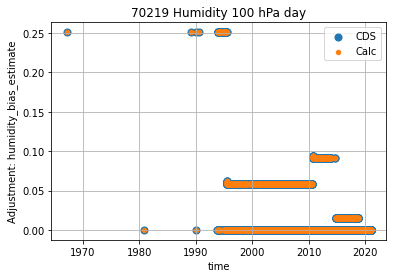

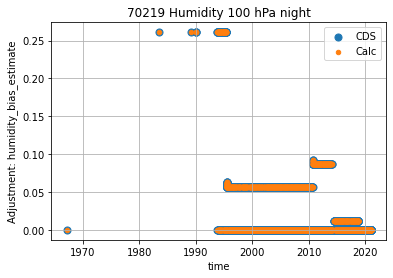

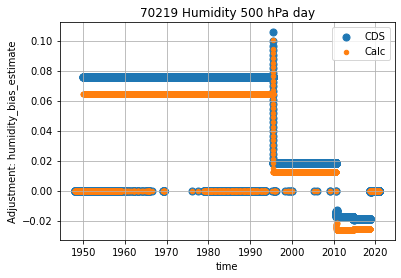

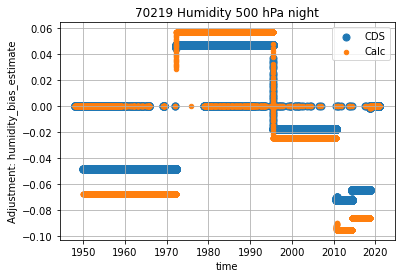

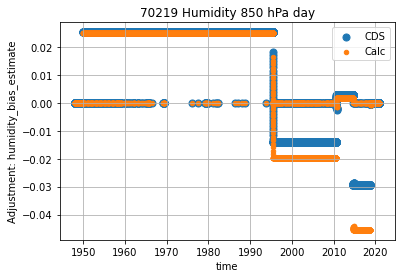

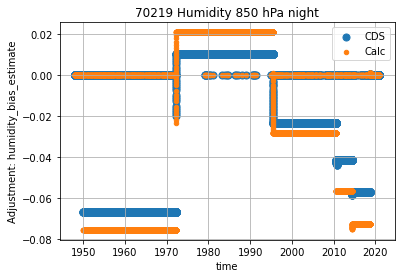

In [4]:
station = '70219'
dd, nd, dcd, ncd = get_adj(station)

plt_adj(dcd, dd, 100, station, 'day', 'humidity_bias_estimate', save=True)
plt_adj(ncd, nd, 100, station, 'night', 'humidity_bias_estimate', save=True)
plt_adj(dcd, dd, 500, station, 'day', 'humidity_bias_estimate', save=True)
plt_adj(ncd, nd, 500, station, 'night', 'humidity_bias_estimate', save=True)
plt_adj(dcd, dd, 850, station, 'day', 'humidity_bias_estimate', save=True)
plt_adj(ncd, nd, 850, station, 'night', 'humidity_bias_estimate', save=True)

2021-05-05 14:27:21,571 INFO Reading Profile on slice(None, None, None)
2021-05-05 14:27:23,849 INFO Welcome to the CDS
2021-05-05 14:27:23,851 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-05-05 14:27:24,307 INFO Request is completed
2021-05-05 14:27:24,309 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1620052532.692893-14260-11-d1cb52e0-511a-4912-b374-6f66ea809c93.zip to download.zip (22.7M)
2021-05-05 14:27:27,396 INFO Download rate 7.4M/s   
2021-05-05 14:27:27,716 INFO Reading Profile on slice(None, None, None)


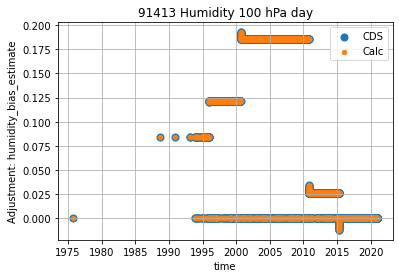

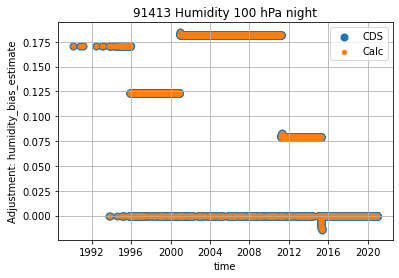

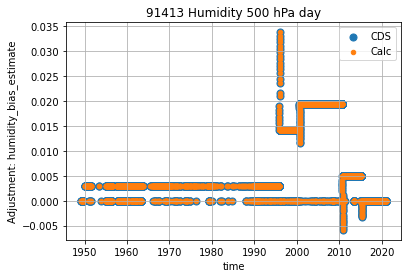

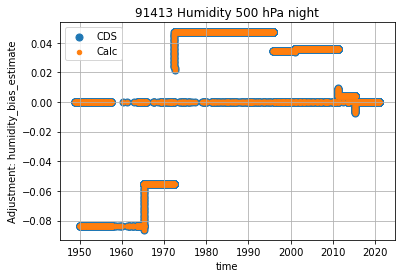

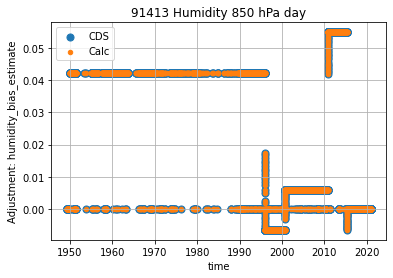

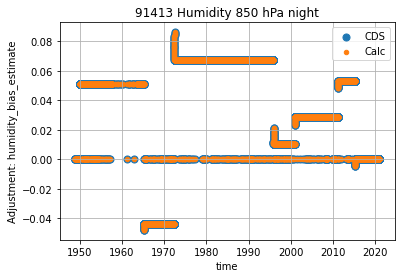

In [5]:
station = '91413'
dd, nd, dcd, ncd = get_adj(station)

plt_adj(dcd, dd, 100, station, 'day', 'humidity_bias_estimate', save=True)
plt_adj(ncd, nd, 100, station, 'night', 'humidity_bias_estimate', save=True)
plt_adj(dcd, dd, 500, station, 'day', 'humidity_bias_estimate', save=True)
plt_adj(ncd, nd, 500, station, 'night', 'humidity_bias_estimate', save=True)
plt_adj(dcd, dd, 850, station, 'day', 'humidity_bias_estimate', save=True)
plt_adj(ncd, nd, 850, station, 'night', 'humidity_bias_estimate', save=True)

2021-05-05 14:27:35,952 INFO Reading Profile on slice(None, None, None)
2021-05-05 14:27:38,275 INFO Welcome to the CDS
2021-05-05 14:27:38,277 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-05-05 14:27:38,487 INFO Request is completed
2021-05-05 14:27:38,489 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1620042926.6514504-17772-7-5da21943-5a67-49a2-98ed-875cb79a39f6.zip to download.zip (17.5M)
2021-05-05 14:27:41,080 INFO Download rate 6.8M/s   
2021-05-05 14:27:41,356 INFO Reading Profile on slice(None, None, None)


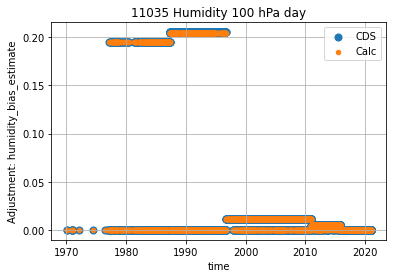

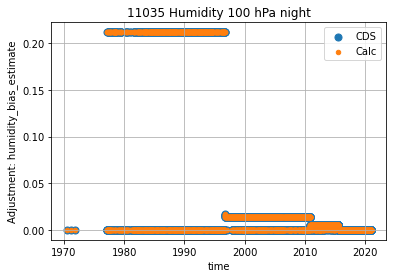

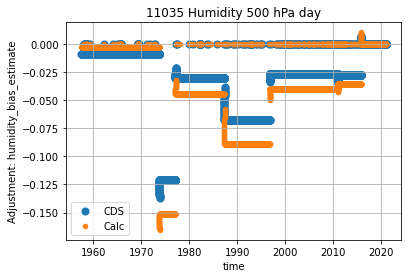

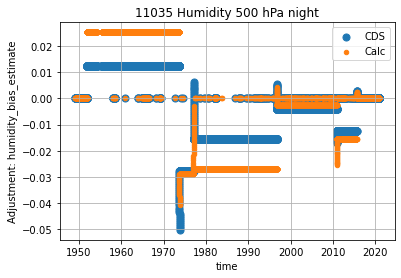

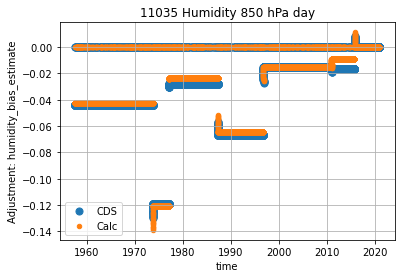

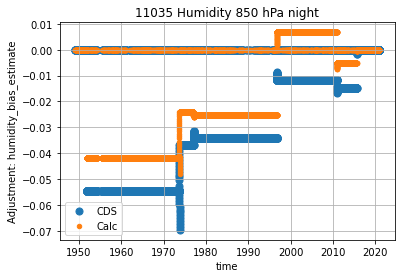

In [6]:
station = '11035'
dd, nd, dcd, ncd = get_adj(station)

plt_adj(dcd, dd, 100, station, 'day', 'humidity_bias_estimate', save=True)
plt_adj(ncd, nd, 100, station, 'night', 'humidity_bias_estimate', save=True)
plt_adj(dcd, dd, 500, station, 'day', 'humidity_bias_estimate', save=True)
plt_adj(ncd, nd, 500, station, 'night', 'humidity_bias_estimate', save=True)
plt_adj(dcd, dd, 850, station, 'day', 'humidity_bias_estimate', save=True)
plt_adj(ncd, nd, 850, station, 'night', 'humidity_bias_estimate', save=True)

2021-05-05 14:27:50,913 INFO Reading Profile on slice(None, None, None)
2021-05-05 14:27:54,279 INFO Welcome to the CDS
2021-05-05 14:27:54,281 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-05-05 14:27:54,452 INFO Request is completed
2021-05-05 14:27:54,453 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data1/adaptor.comprehensive_upper_air.retrieve-1620216036.066979-20710-10-bbc48c48-1469-49e5-a7ed-0459016b4468.zip to download.zip (31.6M)
2021-05-05 14:27:58,531 INFO Download rate 7.7M/s   
2021-05-05 14:27:58,977 INFO Reading Profile on slice(None, None, None)


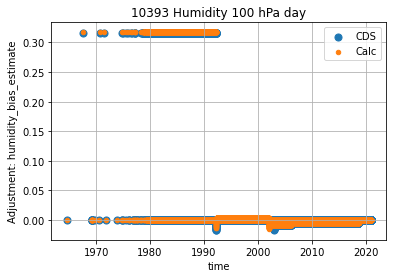

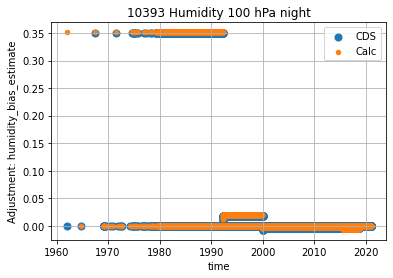

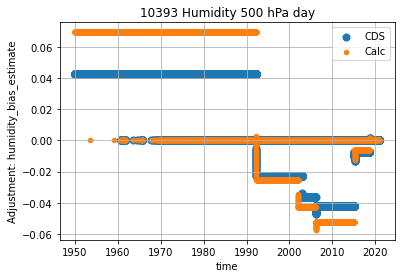

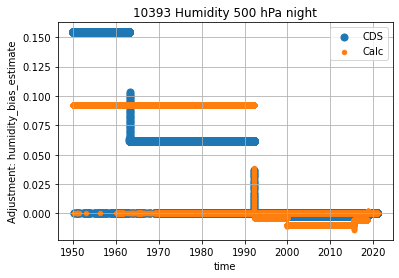

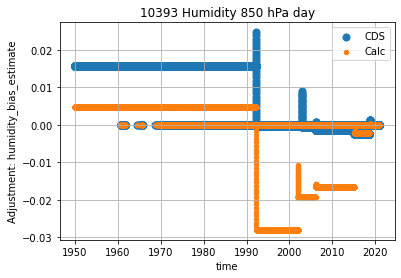

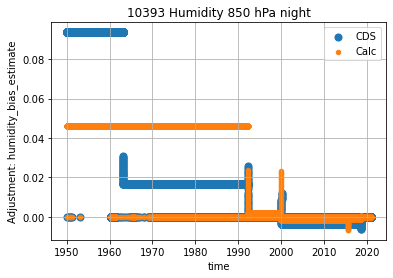

In [7]:
station = '10393'
dd, nd, dcd, ncd = get_adj(station)

plt_adj(dcd, dd, 100, station, 'day', 'humidity_bias_estimate', save=True)
plt_adj(ncd, nd, 100, station, 'night', 'humidity_bias_estimate', save=True)
plt_adj(dcd, dd, 500, station, 'day', 'humidity_bias_estimate', save=True)
plt_adj(ncd, nd, 500, station, 'night', 'humidity_bias_estimate', save=True)
plt_adj(dcd, dd, 850, station, 'day', 'humidity_bias_estimate', save=True)
plt_adj(ncd, nd, 850, station, 'night', 'humidity_bias_estimate', save=True)